# Lecture 8 - Adiabatic sweep

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johannson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

## Introduction

In adiabatic quantum computing, an easy to prepare ground state of a Hamiltonian $H_0$ is prepared, and then the Hamiltonian is gradually transformed into $H_1$, which is constructed in such a way that the groundstate of $H_1$ encodes the solution to a difficult problem. The transformation of $H_0$ to $H_1$ can for example be written on the form

$\displaystyle H(t) = \lambda(t) H_0 + (1 - \lambda(t)) H_1$

where $\lambda(t)$ is a function that goes from goes from $0$ to $1$ when $t$ goes from $0$ to $t_{\rm final}$.

If this gradual tranformation is slow enough (satisfying the adiabicity critera), the evolution of the system will remain in its ground state.

If the Hamiltonian is transformed from $H_0$ to $H_1$ too quickly, the system will get excited from the ground state the adiabatic computing algorithm fails.

In this notebook we explore the dynamics of a spin Hamiltonian that is transformed from a simple Hamiltonian with an easy to prepare ground state, into a random spin Hamiltonian with a complicated ground state.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (QobjEvo, about, basis, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor)

%matplotlib inline

### Parameters

In [2]:
N = 6  # number of spins
M = 20  # number of eigenenergies to plot

# array of spin energy splittings and coupling strengths (random values).
h = 1.0 * 2 * np.pi * (1 - 2 * np.random.rand(N))
Jz = 1.0 * 2 * np.pi * (1 - 2 * np.random.rand(N))
Jx = 1.0 * 2 * np.pi * (1 - 2 * np.random.rand(N))
Jy = 1.0 * 2 * np.pi * (1 - 2 * np.random.rand(N))

# increase taumax to get make the sweep more adiabatic
taumax = 5.0
taulist = np.linspace(0, taumax, 100)

### Precalculate operators

In [3]:
# pre-allocate operators
si = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()

sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = sy
    sy_list.append(tensor(op_list))

    op_list[n] = sz
    sz_list.append(tensor(op_list))

### Construct the initial state

In [4]:
psi_list = [basis(2, 0) for n in range(N)]
psi0 = tensor(psi_list)
H0 = 0
for n in range(N):
    H0 += -0.5 * 2.5 * sz_list[n]

### Construct the Hamiltonian

In [5]:
# energy splitting terms
H1 = 0
for n in range(N):
    H1 += -0.5 * h[n] * sz_list[n]

H1 = 0
for n in range(N - 1):
    # interaction terms
    H1 += -0.5 * Jx[n] * sx_list[n] * sx_list[n + 1]
    H1 += -0.5 * Jy[n] * sy_list[n] * sy_list[n + 1]
    H1 += -0.5 * Jz[n] * sz_list[n] * sz_list[n + 1]

# the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [H0, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [H1, lambda t, args: t / args["t_max"]],
]

# transform Hamiltonian to QobjEvo
h_t = QobjEvo(h_t, args=args)

### Evolve the system in time

In [6]:
#
# callback function for each time-step
#
evals_mat = np.zeros((len(taulist), M))
P_mat = np.zeros((len(taulist), M))

idx = [0]


def process_rho(tau, psi):

    # evaluate the Hamiltonian with gradually switched on interaction
    H = h_t(tau)

    # find the M lowest eigenvalues of the system
    evals, ekets = H.eigenstates(eigvals=M)

    evals_mat[idx[0], :] = np.real(evals)

    # find the overlap between the eigenstates and psi
    for n, eket in enumerate(ekets):
        P_mat[idx[0], n] = abs((eket.dag() * psi)) ** 2

    idx[0] += 1

In [7]:
# Evolve the system, request the solver to call process_rho at each time step.

mesolve(h_t, psi0, taulist, [], process_rho, args)

10.1%. Run time:   0.02s. Est. time left: 00:00:00:00


20.2%. Run time:   0.04s. Est. time left: 00:00:00:00


30.3%. Run time:   0.06s. Est. time left: 00:00:00:00


40.4%. Run time:   0.08s. Est. time left: 00:00:00:00


50.5%. Run time:   0.10s. Est. time left: 00:00:00:00


60.6%. Run time:   0.12s. Est. time left: 00:00:00:00


70.7%. Run time:   0.14s. Est. time left: 00:00:00:00


80.8%. Run time:   0.16s. Est. time left: 00:00:00:00


90.9%. Run time:   0.18s. Est. time left: 00:00:00:00


100.0%. Run time:   0.20s. Est. time left: 00:00:00:00


Total run time:   0.20s


<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.000209808349609375
    preparation time: 0.0033555030822753906
    run time: 0.2011106014251709
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 5.0] (100 steps)
  Number of e_ops: 1
  State not saved.
>

## Visualize the results

Plot the energy levels and the corresponding occupation probabilities (encoded as the width of each line in the energy-level diagram).

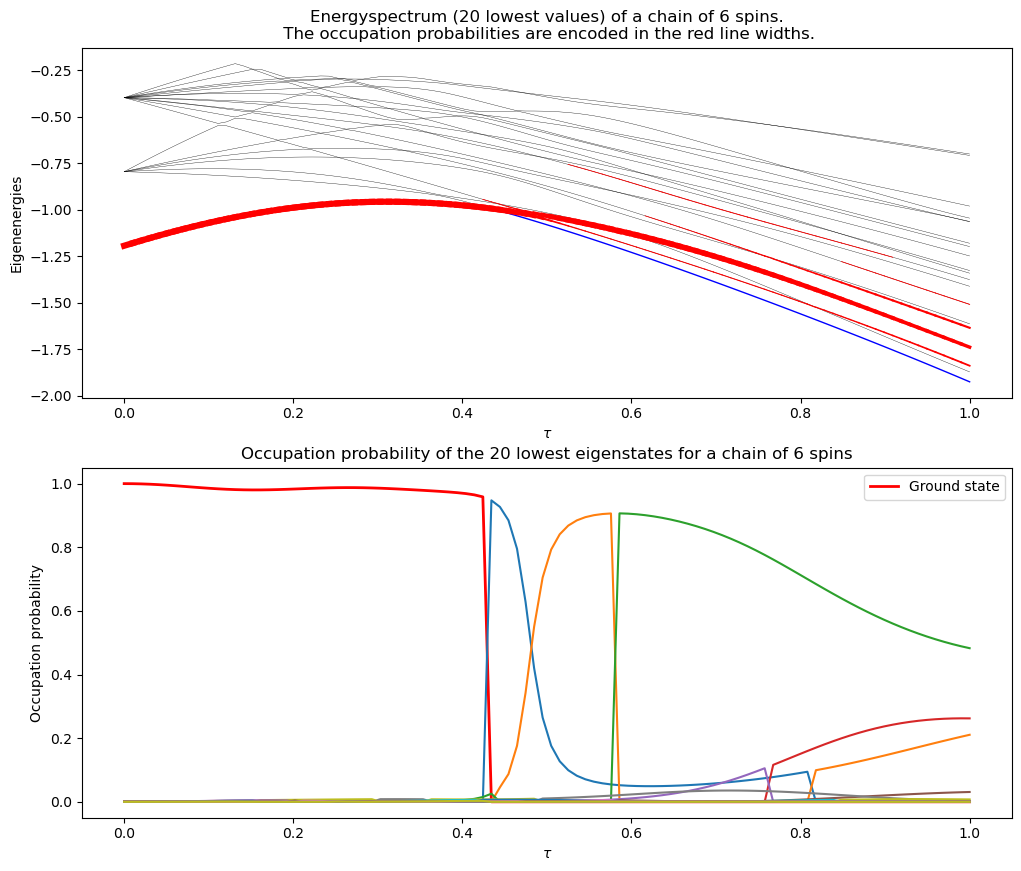

In [8]:
# rc('font', family='serif')
# rc('font', size='10')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

#
# plot the energy eigenvalues
#

# first draw thin lines outlining the energy spectrum
for n in range(len(evals_mat[0, :])):
    ls, lw = ("b", 1) if n == 0 else ("k", 0.25)
    axes[0].plot(taulist / max(taulist), evals_mat[:, n] / (2 * np.pi),
                 ls, lw=lw)

# second, draw line that encode the occupation probability of each state in
# its linewidth. thicker line => high occupation probability.
for idx in range(len(taulist) - 1):
    for n in range(len(P_mat[0, :])):
        lw = 0.5 + 4 * P_mat[idx, n]
        if lw > 0.55:
            axes[0].plot(
                np.array([taulist[idx], taulist[idx + 1]]) / taumax,
                np.array([evals_mat[idx, n],
                          evals_mat[idx + 1, n]]) / (2 * np.pi),
                "r",
                linewidth=lw,
            )

axes[0].set_xlabel(r"$\tau$")
axes[0].set_ylabel("Eigenenergies")
axes[0].set_title(
    "Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M, N)
    + "The occupation probabilities are encoded in the red line widths."
)

#
# plot the occupation probabilities for the few lowest eigenstates
#
for n in range(len(P_mat[0, :])):
    if n == 0:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n], "r", linewidth=2)
    else:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n])

axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Occupation probability")
axes[1].set_title(
    "Occupation probability of the %d lowest " % M
    + "eigenstates for a chain of %d spins" % N
)
axes[1].legend(("Ground state",));

### Software versions:

In [9]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.0.dev0+afd160b
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.33
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `